<a href="https://colab.research.google.com/github/LongNguyen1984/DeepLearning/blob/master/DeepNNCiFar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()



170508288/170498071 [==============================] - 2s 0us/step


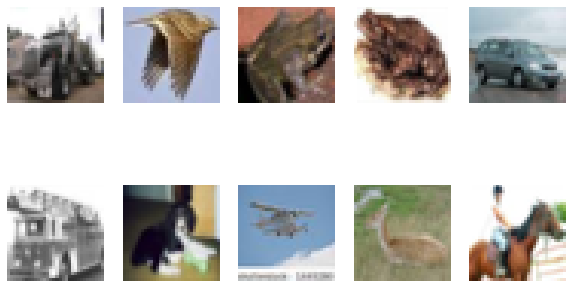

In [8]:
from matplotlib import pyplot
pyplot.rcParams['figure.figsize'] = [10, 6] 
for i in range(10):
  pyplot.subplot(2,5, 1+ i)
  pyplot.imshow(x_train[122+ i])
  pyplot.axis('off')

In [9]:
n =3
# model version
# orig paper: version = 1 (ResNet v1)
# improved Resnet: version =2 (ResNet v2)
version =1

In [10]:
# computer depth from supplied model parameter n
if version == 1: 
  depth = n*6 + 2
elif version == 2:
  depth = n*9 + 2

In [16]:
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import math

In [17]:
batch_size = 32 #origin paper trained at 128
epochs = 200
data_augmentation = True
num_classes = 10

# subtracting pixel mean improves accuracy
subtracting_pixel_mean = True

In [22]:
num_classes = len(np.unique(y_train))
num_classes

10

In [18]:
# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# if subtract pixel mean is enabled
if subtracting_pixel_mean:
  x_train_mean = np.mean(x_train, axis=0)
  x_train -= x_train_mean
  x_test -= x_train_mean
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [23]:
# covert class vecctors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

### Learning rate scheduler

In [26]:
def lr_schedule(epoch):
  """Learning Rate Schedule
Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
Called automatically every epoch as part of callbacks during training.
# Arguments
  epoch (int): The number of epochs
# Returns
lr (float32): learning rate
  """
  learning_rate = 1e-3
  if epoch > 180:
      learning_rate *= 0.5e-3
  elif epoch > 160:
      learning_rate *= 1e-3
  elif epoch > 120:
      learning_rate *= 1e-2
  elif epoch > 80:
      learning_rate *= 1e-1
  print('Learning rate:', learning_rate)  
  return lr

### Resnet Layer

In [29]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
   """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
   """
   conv = Conv2D(num_filters,
                  kernel_size = kernel_size,
                  strides = strides,
                  padding ='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer = l2(1e-4))
   x = inputs
   if conv_first:
     x = conv(x)
     if batch_normalization:
       x = BatchNormalization()(x)
     if activation is not None:
       x = Activation(activation)(x)
   else:
     if batch_normalization:
       x = BatchNormalization()(x)
     if activation is not None:
       x = Activation(activation)(x)
     x = conv(x)
   return x
    
    
    

### ResNet V1

In [12]:
def resnet_v1(input_shape, depth, num_classes=10):
  """ ResNet Version 1 Model builder [a]
  Stacks of 2x(3x3) Conv2D-BN-ReLU
  Last ReLU is after the shortcut connection.
  At the begining of each stage, the future map size is halved
  (donwsampled) by a convolutional layer with strides=2, while the number of filters is doubled. 
  Within each stage, the layers have the same number filters and the same number of filters.
  Features map sizes:
  stage 0: 32x32, 16
  stage 1: 16x16, 32
  stage 2: 8x8, 64
  The number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
  Arguments:
    input_shape (tensor): shape of input image tensor 
    depth (int): number of core convolutional layers
    num_classes (int): number of classes (CIFAR10 has 10)
  Returns:
    model (Model): Keras model instance
  """
  if (depth - 2)% 6 != 0:
    raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
  # Start model definition.
  num_filters = 16
  num_res_blocks = int((depth - 2)/6)
  inputs = Input(shape=input_shape)
  x = resnet_layer(inputs=inputs)
  # instantiate the stack of residual units
  for stack in range(3):
    for res_block in range(num_res_blocks):
      strides = 1
      # first lauer but not first stack
      if stack > 0 and res_block == 0:
        strides = 2 # downsample
      y = resnet_layer(input=x,
                       num_filters=num_filters,
                       strides=strides)


In [11]:
if version == 2:
  model = resnet_v2(input_shape=input_shape, depth=depth)
else:
  model = resnet_v1(input_shape=input_shape, depth=depth)


NameError: ignored